In [1]:
# E-commerce Price Monitoring Scraper - Complete Implementation
# This code provides both BeautifulSoup and Scrapy implementations for ethical price monitoring

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from urllib.robotparser import RobotFileParser
import logging
from datetime import datetime

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
class EthicalPriceScraper:
    """
    Ethical Price Scraper Class with built-in compliance checks
    """

    def __init__(self, delay=1, user_agent=None):
        self.delay = delay
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': user_agent or 'EthicalPriceScraper/1.0 (Educational Purpose)'
        })

    def check_robots_txt(self, url):
        """Check if scraping is allowed by robots.txt"""
        try:
            rp = RobotFileParser()
            robots_url = url.split('/')[0] + '//' + url.split('/')[2] + '/robots.txt'
            rp.set_url(robots_url)
            rp.read()
            return rp.can_fetch(self.session.headers['User-Agent'], url)
        except Exception as e:
            logger.warning(f"Could not check robots.txt: {e}")
            return True  # Assume allowed if can't check

    def scrape_books_toscrape(self, max_pages=3):
        """
        Scrape book data from books.toscrape.com (educational site)
        """
        base_url = "http://books.toscrape.com/catalogue/page-{}.html"
        all_data = []

        # Check robots.txt
        if not self.check_robots_txt("http://books.toscrape.com"):
            logger.error("Scraping not allowed by robots.txt")
            return pd.DataFrame()

        logger.info(f"Starting scrape of {max_pages} pages...")

        for page in range(1, max_pages + 1):
            url = base_url.format(page)
            logger.info(f"Scraping page {page}: {url}")

            try:
                response = self.session.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.content, "html.parser")

                # Extract product data
                products = soup.find_all("article", class_="product_pod")

                for product in products:
                    try:
                        # Extract title
                        title_elem = product.find("h3").find("a")
                        title = title_elem.get("title", "N/A")

                        # Extract price
                        price_elem = product.find("p", class_="price_color")
                        price_text = price_elem.text.replace("£", "").strip()
                        price = float(price_text)

                        # Extract availability
                        availability_elem = product.find("p", class_="instock availability")
                        availability = availability_elem.text.strip().replace("\n", " ")

                        # Extract rating
                        rating_elem = product.find("p", class_=lambda x: x and "star-rating" in x)
                        rating = "N/A"
                        if rating_elem:
                            rating_classes = rating_elem.get("class", [])
                            for cls in rating_classes:
                                if cls in ["One", "Two", "Three", "Four", "Five"]:
                                    rating = cls
                                    break

                        # Get product URL for future monitoring
                        product_url = title_elem.get("href", "N/A")

                        all_data.append({
                            "product_name": title,
                            "price": price,
                            "availability": availability,
                            "rating": rating,
                            "product_url": product_url,
                            "scraped_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                            "page": page
                        })

                    except Exception as e:
                        logger.warning(f"Error extracting product data: {e}")
                        continue

                # Respect rate limiting
                if page < max_pages:
                    logger.info(f"Waiting {self.delay} seconds before next request...")
                    time.sleep(self.delay)

            except Exception as e:
                logger.error(f"Error scraping page {page}: {e}")
                continue

        logger.info(f"Scraped {len(all_data)} products total")
        return pd.DataFrame(all_data)

In [5]:
class DataCleaner:
    """
    Data cleaning and preprocessing utilities
    """

    @staticmethod
    def clean_price_data(df):
        """Clean and validate price data"""
        logger.info("Starting data cleaning...")
        original_count = len(df)

        # Remove duplicates
        df = df.drop_duplicates(subset=['product_name', 'price'])
        logger.info(f"Removed {original_count - len(df)} duplicate entries")

        # Handle missing values
        df = df.dropna(subset=['product_name', 'price'])

        # Ensure price is numeric
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df = df.dropna(subset=['price'])

        # Remove unrealistic prices (negative or extremely high)
        df = df[(df['price'] > 0) & (df['price'] < 1000)]

        # Clean availability text
        df['availability'] = df['availability'].str.replace('\n', ' ').str.strip()

        # Extract stock numbers
        df['stock_count'] = df['availability'].str.extract(r'(\d+)').astype('Int64')

        logger.info(f"Cleaning complete. Final dataset: {len(df)} products")
        return df.reset_index(drop=True)

    @staticmethod
    def add_price_categories(df):
        """Add price categories for analysis"""
        df['price_category'] = pd.cut(
            df['price'],
            bins=[0, 20, 40, 60, 100],
            labels=['Budget', 'Medium', 'Premium', 'Luxury'],
            include_lowest=True
        )
        return df

In [6]:
class PriceVisualizer:
    """
    Visualization utilities for price analysis
    """

    @staticmethod
    def create_price_distribution_plot(df, save_path=None):
        """Create price distribution histogram"""
        plt.figure(figsize=(12, 8))

        # Main histogram
        plt.subplot(2, 2, 1)
        sns.histplot(df['price'], bins=20, kde=True, color='skyblue', alpha=0.7)
        plt.title('Price Distribution of Books')
        plt.xlabel('Price (£)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # Box plot
        plt.subplot(2, 2, 2)
        sns.boxplot(y=df['price'], color='lightcoral')
        plt.title('Price Box Plot')
        plt.ylabel('Price (£)')

        # Price by rating
        if 'rating' in df.columns:
            plt.subplot(2, 2, 3)
            rating_order = ['One', 'Two', 'Three', 'Four', 'Five']
            sns.boxplot(data=df, x='rating', y='price', order=rating_order)
            plt.title('Price by Rating')
            plt.xlabel('Rating')
            plt.ylabel('Price (£)')
            plt.xticks(rotation=45)

        # Price categories
        if 'price_category' in df.columns:
            plt.subplot(2, 2, 4)
            df['price_category'].value_counts().plot(kind='bar', color='gold', alpha=0.7)
            plt.title('Books by Price Category')
            plt.xlabel('Price Category')
            plt.ylabel('Count')
            plt.xticks(rotation=45)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Plot saved to {save_path}")

        plt.show()

    @staticmethod
    def create_summary_stats(df):
        """Generate summary statistics"""
        stats = {
            'total_products': len(df),
            'avg_price': df['price'].mean(),
            'median_price': df['price'].median(),
            'min_price': df['price'].min(),
            'max_price': df['price'].max(),
            'std_price': df['price'].std(),
            'price_range': df['price'].max() - df['price'].min()
        }

        logger.info("=== PRICE MONITORING SUMMARY ===")
        logger.info(f"Total Products Scraped: {stats['total_products']}")
        logger.info(f"Average Price: £{stats['avg_price']:.2f}")
        logger.info(f"Median Price: £{stats['median_price']:.2f}")
        logger.info(f"Price Range: £{stats['min_price']:.2f} - £{stats['max_price']:.2f}")
        logger.info(f"Price Standard Deviation: £{stats['std_price']:.2f}")

        return stats

In [7]:
def main():
    """
    Main execution function demonstrating the complete workflow
    """
    logger.info("=== E-COMMERCE PRICE MONITORING SCRAPER ===")
    logger.info("Educational implementation using books.toscrape.com")

    # Initialize scraper with ethical settings
    scraper = EthicalPriceScraper(delay=1)

    # Scrape data
    raw_df = scraper.scrape_books_toscrape(max_pages=3)

    if raw_df.empty:
        logger.error("No data was scraped. Exiting.")
        return

    # Clean data
    cleaner = DataCleaner()
    clean_df = cleaner.clean_price_data(raw_df)
    clean_df = cleaner.add_price_categories(clean_df)

    # Save cleaned data
    output_file = f"scraped_book_prices_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    clean_df.to_csv(output_file, index=False)
    logger.info(f"Clean data saved to {output_file}")

    # Generate visualizations
    visualizer = PriceVisualizer()
    plot_file = f"price_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    visualizer.create_price_distribution_plot(clean_df, save_path=plot_file)

    # Generate summary statistics
    stats = visualizer.create_summary_stats(clean_df)

    # Display sample data
    logger.info("\n=== SAMPLE DATA ===")
    print(clean_df[['product_name', 'price', 'availability', 'rating', 'price_category']].head(10))

    return clean_df, stats

In [8]:
# SCRAPY IMPLEMENTATION (Alternative approach)
"""
To use Scrapy, create the following files:

1. settings.py:
---
BOT_NAME = 'price_monitor'
SPIDER_MODULES = ['price_monitor.spiders']
NEWSPIDER_MODULE = 'price_monitor.spiders'

ROBOTSTXT_OBEY = True
DOWNLOAD_DELAY = 1
RANDOMIZE_DOWNLOAD_DELAY = 0.5
USER_AGENT = 'price_monitor (+http://www.yourdomain.com)'

2. spiders/book_spider.py:
---
import scrapy
import pandas as pd
from datetime import datetime

class BookSpider(scrapy.Spider):
    name = 'book_spider'
    allowed_domains = ['books.toscrape.com']
    start_urls = ['http://books.toscrape.com/catalogue/page-1.html']

    def parse(self, response):
        # Extract product data
        products = response.css('article.product_pod')

        for product in products:
            yield {
                'product_name': product.css('h3 a::attr(title)').get(),
                'price': product.css('p.price_color::text').re_first(r'£(.+)'),
                'availability': product.css('p.instock.availability::text').getall()[-1].strip(),
                'rating': product.css('p[class*="star-rating"]::attr(class)').re_first(r'star-rating (\w+)'),
                'scraped_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }

        # Follow pagination
        next_page = response.css('li.next a::attr(href)').get()
        if next_page:
            yield response.follow(next_page, self.parse)

# Run with: scrapy crawl book_spider -o prices.json
"""

'\nTo use Scrapy, create the following files:\n\n1. settings.py:\n---\nBOT_NAME = \'price_monitor\'\nSPIDER_MODULES = [\'price_monitor.spiders\']\nNEWSPIDER_MODULE = \'price_monitor.spiders\'\n\nROBOTSTXT_OBEY = True\nDOWNLOAD_DELAY = 1\nRANDOMIZE_DOWNLOAD_DELAY = 0.5\nUSER_AGENT = \'price_monitor (+http://www.yourdomain.com)\'\n\n2. spiders/book_spider.py:\n---\nimport scrapy\nimport pandas as pd\nfrom datetime import datetime\n\nclass BookSpider(scrapy.Spider):\n    name = \'book_spider\'\n    allowed_domains = [\'books.toscrape.com\']\n    start_urls = [\'http://books.toscrape.com/catalogue/page-1.html\']\n    \n    def parse(self, response):\n        # Extract product data\n        products = response.css(\'article.product_pod\')\n        \n        for product in products:\n            yield {\n                \'product_name\': product.css(\'h3 a::attr(title)\').get(),\n                \'price\': product.css(\'p.price_color::text\').re_first(r\'£(.+)\'),\n                \'availabi

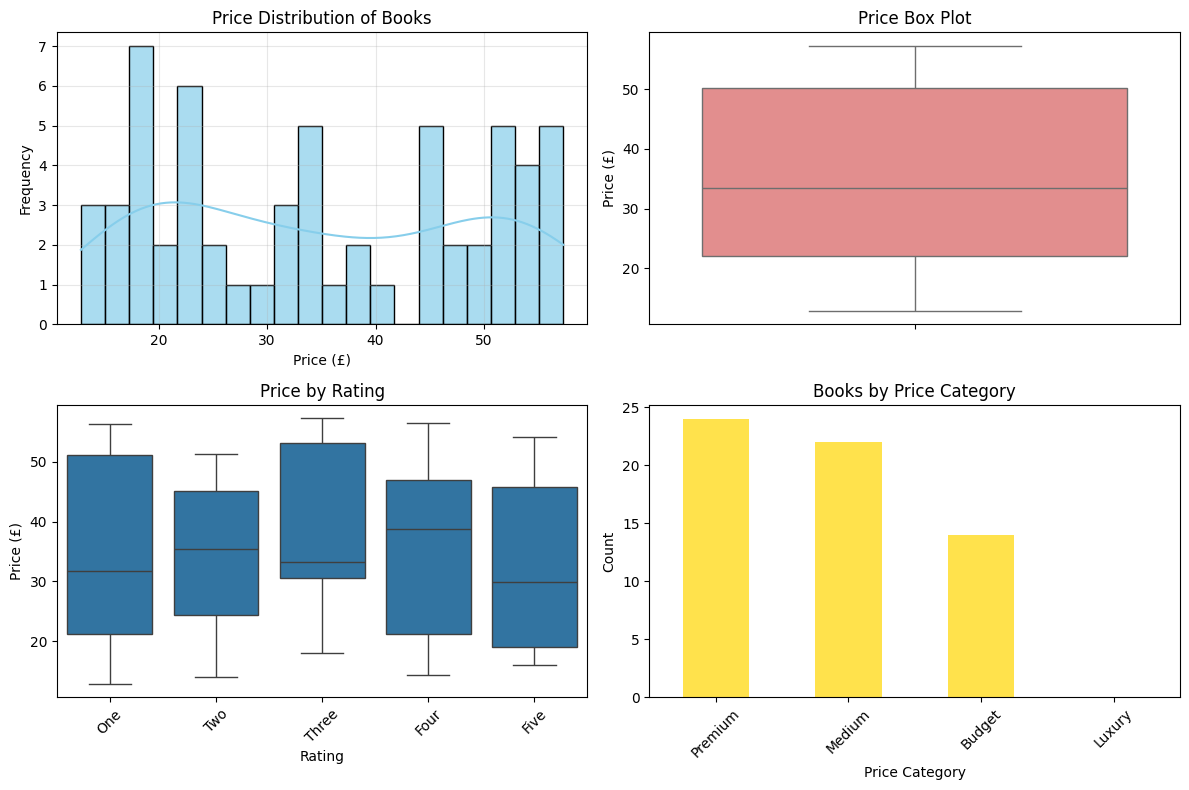

                                        product_name  price availability  \
0                               A Light in the Attic  51.77     In stock   
1                                 Tipping the Velvet  53.74     In stock   
2                                         Soumission  50.10     In stock   
3                                      Sharp Objects  47.82     In stock   
4              Sapiens: A Brief History of Humankind  54.23     In stock   
5                                    The Requiem Red  22.65     In stock   
6  The Dirty Little Secrets of Getting Your Dream...  33.34     In stock   
7  The Coming Woman: A Novel Based on the Life of...  17.93     In stock   
8  The Boys in the Boat: Nine Americans and Their...  22.60     In stock   
9                                    The Black Maria  52.15     In stock   

  rating price_category  
0  Three        Premium  
1    One        Premium  
2    One        Premium  
3   Four        Premium  
4   Five        Premium  
5    On

In [9]:
if __name__ == "__main__":
    # Run the main scraper
    df, stats = main()

    logger.info("=== ETHICAL SCRAPING COMPLETED ===")
    logger.info("Remember: This is for educational purposes only!")
    logger.info("Always respect robots.txt and website terms of service.")